# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
from scipy import linalg
%matplotlib inline

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        words = np.array(list(self.word2vec.keys()))
        scores = np.zeros((len(words)))
        for i, word in enumerate(words):
            scores[i] = self.score(w, word)
        idxs = np.argsort(scores)
        return words[idxs[-(K+1):-1]]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        try:
            vec1 = self.word2vec[w1]
        except KeyError:
            vec1 = self.word2vec[w1.capitalize()]
        try:
            vec2 = self.word2vec[w2]
        except KeyError:
            vec2 = self.word2vec[w2.capitalize()]
        return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
        


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)
# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7058595452409974
germany berlin 0.7060253015336013
['dog' 'Cat' 'kitten' 'kitty' 'cats']
['pup' 'canine' 'Dog' 'puppy' 'dogs']
['canine' 'cats' 'puppies' 'Dogs' 'dog']
['Bordeaux' 'Lyon' 'Versailles' 'France' 'Parisian']
['German' 'Munich' 'Berlin' 'Bavaria' 'Austria']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v

    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            word_list = sent.split(' ')
            if idf is False:
                weighted_vectors = []
                for w in word_list:
                    try:
                        weighted_vectors.append(self.w2v.word2vec[w])
                    except KeyError:
                        pass # if the word isn't in the word2vec vocab pass 
                if weighted_vectors:
                    sentemb.append((np.mean(weighted_vectors, axis=0))[None,:])
                else:
                    sentemb.append(np.zeros((300,))) # if all words in sent aren't in word2vec vocab, encode with an array of zeros
            else:
                weighted_vectors = []
                for w in word_list:
                    try:
                        weighted_vectors.append(self.w2v.word2vec[w]*idf[w])
                    except KeyError:
                        pass 
                if weighted_vectors:
                    sentemb.append((np.mean(weighted_vectors, axis=0))[None,:])
                else:
                    sentemb.append(np.zeros((300,)))
        
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        scores = np.zeros((len(sentences)))
        for i, key in enumerate(sentences):
            scores[i] = self.score(key, s, idf)
        idxs = np.argsort(scores)
        output = [(sentences[idx], scores[idx]) for idx in idxs[-(K+1):-1]]
        print(output)
        return output
        

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        emb1 = self.encode([s1], idf)[0]
        emb2 = self.encode([s2], idf)[0]
        norm1 = np.linalg.norm(emb1)
        norm2 = np.linalg.norm(emb2)
        if norm1 == 0 or norm2 == 0: # If s1 or s2 was encoded as an array of zeros (contained no words in the word2vec vocab)
            score = -1
        else:
            score = np.dot(emb1, emb2)/(norm1*norm2)
        return score
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            sent = sent.split(' ')
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf
        

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt')) as file:
    lines = file.readlines()
sentences = [line.strip(' \n') for line in lines]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('Input sentence : ' + sentences[10])
s2v.most_similar('' if not sentences else sentences[10], sentences, idf=False)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf=False))


 
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 200000 pretrained word vectors
Input sentence : 1 smiling african american boy .
[('a girl in black hat holding an african american baby .', 0.8191122491011851), ('an african american man is sitting .', 0.8207047384633509), ('an afican american woman standing behind two small african american children .', 0.8217139139540895), ('a little african american boy and girl looking up .', 0.8498556003875812), ('an african american man smiling .', 0.9170453357707757)]
0.5726258859719607
[('a girl in black hat holding an african american baby .', 0.846157865119249), ('an afican american woman standing behind two small african american children .', 0.8546787739055061), ('a little african american boy and girl looking up .', 0.8649160645466021), ('an african american man is sitting .', 0.8710560062973776), ('an african american man smiling .', 0.9215230615776525)]
0.4751450875368782


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
def load_file(path, nmax):
    output = {}
    with io.open(path, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            output[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    return output

eng_file = os.path.join(PATH_TO_DATA, 'wiki.en.vec')
fr_file = os.path.join(PATH_TO_DATA, 'wiki.fr.vec')
nmax = 50000
wiki_en = load_file(eng_file, nmax)
wiki_fr = load_file(fr_file, nmax)

In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
X = []
Y = []
for word in wiki_fr.keys():
    if word in wiki_en.keys():
        X.append(wiki_fr[word])
        Y.append(wiki_en[word])
X = np.array(X).T
Y = np.array(Y).T
print(X.shape)

(300, 18970)


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U, s, V = linalg.svd(np.dot(Y, X.T)) 
W = np.dot(U, V)

print(np.linalg.norm(Y-np.dot(W, X)))

583.8934480686562


In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
french_words = ['robe', 'agent', 'jaune', 'roi', 'ciel']
english_words = ['story', 'brain', 'knee', 'spy', 'whale']

def most_similar(word, lang='fr', K=5):
    if lang == 'fr':
        original_embed = wiki_fr[word][:,None]
        keys = list(wiki_en.keys())
        scores = np.zeros((len(keys)))
        embed = np.dot(W, original_embed)
        for i, w in enumerate(keys):
            emb = wiki_en[w]
            scores[i] = np.dot(emb, embed)/(np.linalg.norm(emb)*np.linalg.norm(embed))
    elif lang == 'en':
        original_embed = wiki_en[word][:,None]
        keys = list(wiki_fr.keys())
        scores = np.zeros((len(keys)))
        embed = np.dot(np.linalg.inv(W), original_embed)
        for i, w in enumerate(keys):
            emb = wiki_fr[w]
            scores[i] = np.dot(emb, embed)/(np.linalg.norm(emb)*np.linalg.norm(embed))
    idxs = np.argsort(scores)
    output = [keys[idx] for idx in idxs[-K:]]
    return output

for w in french_words:
    print('Most similar to {} : {}'.format(w, most_similar(w, lang='fr')))
print('---------------------------------------------------------------')
for w in english_words:
    print('Most similar to {} : {}'.format(w, most_similar(w, lang='en')))

Most similar to robe : ['dresses', 'gowns', 'robes', 'blouse', 'gown']
Most similar to agent : ['fbi', 'informant', 'undercover', 'agents', 'agent']
Most similar to jaune : ['bluish', 'pinkish', 'reddish', 'yellowish', 'yellow']
Most similar to roi : ['usurper', 'throne', 'kingship', 'vassal', 'king']
Most similar to ciel : ['heavens', 'skyscrapers', 'skies', 'sky', 'skyscraper']
---------------------------------------------------------------
Most similar to story : ['racontant', 'autobiographique', 'raconte', 'récit', 'roman']
Most similar to brain : ['cérébrale', 'cérébraux', 'cérébrales', 'cérébral', 'cerveau']
Most similar to knee : ['cheville', 'blessure', 'ligaments', 'hanche', 'genou']
Most similar to spy : ['espions', 'espionner', 'espionnage', 'espionne', 'espion']
Most similar to whale : ['requins', 'phoque', 'phoques', 'baleines', 'baleine']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_train_val_file(path):
    sentences = []
    labels = []
    with io.open(path) as f:
        next(f)
        for i, line in enumerate(f):
            label, sent = line.split(' ', 1)
            sentences.append(sent)
            labels.append(int(label))
    return (sentences, labels)

def load_test_file(path):
    sentences = []
    with io.open(path) as f:
        next(f)
        for i, line in enumerate(f):
            sentences.append(line.strip('\n'))
    return sentences

train_file = os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train')
val_file = os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev')
test_file = os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X')
train_sent, train_labels = load_train_val_file(train_file)
val_sent, val_labels = load_train_val_file(val_file)
test_sent = load_test_file(test_file)

In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
idf_train = s2v.build_idf(train_sent)
idf_val = s2v.build_idf(val_sent)
train_vec_mean = s2v.encode(train_sent, idf=False)
train_vec_idf = s2v.encode(train_sent, idf_train)
val_vec_mean = s2v.encode(val_sent, idf=False)
val_vec_idf = s2v.encode(val_sent, idf_val)

In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

model1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=100, max_iter=1000).fit(train_vec_mean, train_labels)
print('Training accuracy (average) : {}'.format(model1.score(train_vec_mean, np.array(train_labels))))
print('Validation accuracy (average) : {}'.format(model1.score(val_vec_mean, np.array(val_labels))))

model2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=100, max_iter=1000).fit(train_vec_idf, train_labels)
print('Training accuracy (idf-weighted) : {}'.format(model2.score(train_vec_idf, np.array(train_labels))))
print('Validation accuracy (idf-weighted) : {}'.format(model2.score(val_vec_idf, np.array(val_labels))))

Training accuracy (average) : 0.5036872293105467
Validation accuracy (average) : 0.42363636363636364
Training accuracy (idf-weighted) : 0.49549338639822077
Validation accuracy (idf-weighted) : 0.4163636363636364


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
test_vec = s2v.encode(test_sent)
test_labels = model1.predict(test_vec)
output = ['{} \n'.format(i) for i in test_labels]
with open("logreg_bov_y_test_sst.txt", "w") as f:
    f.writelines(list(output))

In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.svm import SVC

model1 = SVC(kernel='rbf',
            decision_function_shape='ovr', C=1000, gamma='auto').fit(train_vec_mean, train_labels)
print('Training accuracy (average) : {}'.format(model1.score(train_vec_mean, np.array(train_labels))))
print('Validation accuracy (average) : {}'.format(model1.score(val_vec_mean, np.array(val_labels))))

model2 = SVC(kernel='rbf',
            decision_function_shape='ovr', C=100, gamma='auto').fit(train_vec_idf, train_labels)
print('Training accuracy (idf-weighted) : {}'.format(model2.score(train_vec_idf, np.array(train_labels))))
print('Validation accuracy (idf-weighted) : {}'.format(model2.score(val_vec_idf, np.array(val_labels))))


# Making predictions for test set and saving results
test_labels = model2.predict(test_vec)
output = ['{} \n'.format(i) for i in test_labels]
with open("svm_bov_y_test_sst.txt", "w") as f:
    f.writelines(list(output))

Training accuracy (average) : 0.5311951305162121
Validation accuracy (average) : 0.43454545454545457
Training accuracy (idf-weighted) : 0.5587030317218775
Validation accuracy (idf-weighted) : 0.43454545454545457


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras

Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
#PATH_TO_DATA = "../../data/"

# TYPE CODE HERE
train_sent, train_labels = load_train_val_file(train_file)
val_sent, val_labels = load_train_val_file(val_file)
test_sent = load_test_file(test_file)

y_train = keras.utils.np_utils.to_categorical(train_labels)
y_val = keras.utils.np_utils.to_categorical(val_labels)

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
tokenizer = keras.preprocessing.text.Tokenizer(num_words=15477, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=" ")
tokenizer.fit_on_texts(train_sent)
x_train = tokenizer.texts_to_sequences(train_sent)
x_val = tokenizer.texts_to_sequences(val_sent)
x_test = tokenizer.texts_to_sequences(test_sent)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=50, dtype='int32', padding='pre', value=0.0)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=50, dtype='int32', padding='pre', value=0.0)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=50, dtype='int32', padding='pre', value=0.0)



## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 64  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 15477  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=x_train.shape[1]))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            990528    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,089,989
Trainable params: 1,089,989
Non-trainable params: 0
_________________________________________________________________
None


Train on 8543 samples, validate on 1100 samples
Epoch 1/6
8543/8543 [==============================] - 68s 8ms/step - loss: 1.5617 - acc: 0.2810 - val_loss: 1.5124 - val_acc: 0.3245
Epoch 2/6
8543/8543 [==============================] - 59s 7ms/step - loss: 1.3160 - acc: 0.4061 - val_loss: 1.3504 - val_acc: 0.3891
Epoch 3/6
8543/8543 [==============================] - 59s 7ms/step - loss: 1.0215 - acc: 0.5209 - val_loss: 1.5030 - val_acc: 0.3973
Epoch 4/6
8543/8543 [==============================] - 63s 7ms/step - loss: 0.7415 - acc: 0.7005 - val_loss: 1.7233 - val_acc: 0.3700
Epoch 5/6
8543/8543 [==============================] - 64s 7ms/step - loss: 0.4825 - acc: 0.8207 - val_loss: 2.0485 - val_acc: 0.3482
Epoch 6/6
8543/8543 [==============================] - 62s 7ms/step - loss: 0.3414 - acc: 0.8833 - val_loss: 2.3273 - val_acc: 0.3600


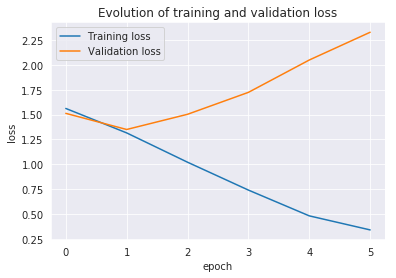

In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 32
n_epochs = 6
history = model.fit(x_train, y_train, batch_size=bs,epochs=n_epochs, validation_data=(x_val, y_val))

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Evolution of training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
test_labels = np.argmax(model.predict(x_test), axis=1)
output = ['{} \n'.format(i) for i in test_labels]
with open("logreg_lstm_y_test_sst.txt", "w") as f:
    f.writelines(output)

## 4.3 -- innovate !

In [24]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.layers import Conv1D, MaxPooling1D, Bidirectional
from keras.regularizers import l2

max_len = 52

def encode(sentences):
    '''Transforms list of sentences into numpy array of word2vec embeddings'''
    embed = []
    for sent in sentences:
        sentemb = []
        for w in sent:
            try:
                sentemb.append(w2v.word2vec[w])
            except KeyError:
                sentemb.append(np.zeros(300,))
        sent_len = len(sentemb)
        if sent_len < max_len:
            for i in range(max_len-sent_len):
                sentemb.append(np.zeros(300,))
        embed.append(np.vstack(sentemb))
    return np.stack(embed)

x_train =  [keras.preprocessing.text.text_to_word_sequence(sent) for sent in train_sent]
x_val =  [keras.preprocessing.text.text_to_word_sequence(sent) for sent in val_sent]
x_test =  [keras.preprocessing.text.text_to_word_sequence(sent) for sent in test_sent]

x_train = encode(x_train)
x_val = encode(x_val)
x_test = encode(x_test)

nhid = 100

model = Sequential()
model.add(Conv1D(64, 5, activation='relu', padding='same', input_shape=(52,300)))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(nhid, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' 
optimizer        =  'nadam' 
metrics_classif  =  ['accuracy']
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 16
n_epochs = 6
history = model.fit(x_train, y_train, batch_size=bs,epochs=n_epochs, validation_data=(x_val, y_val))

test_labels = np.argmax(model.predict(x_test), axis=1)
output = ['{} \n'.format(i) for i in test_labels]
with open("w2v_1Dconv_LSTM_y_test_sst.txt", "w") as f:
    f.writelines(list(output))
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 52, 64)            96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 162,569
Trainable params: 162,569
Non-trainable params: 0
_________________________________________________________________
None
Train on 8543 samples, validate on 1100 samples
Epoch 1/6
8543/8543 [==============================] - 52s 6ms/step - loss: 1.3856 - acc: 0.3781 - val_loss: 1.2948 - val_acc: 0.4045
Epoch 2/6
8543/8543 [==============================] - 46s 5ms/step - loss: 1.217